# INFO 3402 – Class 34: Intermediate regression

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Credit also goes to Jake VanderPlas's *[Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)* and Justin Markham's [DAT4](https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb) notebooks.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd

pd.options.display.max_columns = 200

import statsmodels.formula.api as smf
import statsmodels.api as sm

We will use the popular [diamonds](https://github.com/tidyverse/ggplot2/blob/master/data-raw/diamonds.csv) dataset to explore some of the issues with linear regression.

* **`carat`** - the weight of the diamond. Continuous: 0.2—5.01
* **`cut`** - the quality of the diamond. Categorical: Fair, Good, Very Good, Premium, Ideal
* **`color`** - the color of the diamond. Categorical: J (worst) to D (best)
* **`clarity`** - another measure of quality. Categorical: I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
* **`depth`** - the total depth percentage = $z / mean(x, y) = 2 * z / (x + y)$. Continuous: 43—79
* **`table`** - width of top of diamond relative to widest point. Continuous: 43—95
* **`price`** - price of the diamond in dollars. Continuous: \$326—\$18,823
* **`x`,`y`,`z`** - the dimensions of the diamond in millimeters. Continuous: 0—58.9

In [2]:
diamonds_df = pd.read_csv('diamonds.csv',index_col=0)
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Assumption 0: Continuous data against continuous data

The 0th assumption about linear regression is that the outcome (dependent variable, Y, *etc*.) has to be continuous. Dollars, mass, percentages, area, *etc*. are continuous but **not** variables like binary, categories, strings, etc.

A (potentially) reasonable model is predicting the price as a function of the dimensions and weight.

First, create some exploratory bivariate plots of the relationship between the dimensions and price.

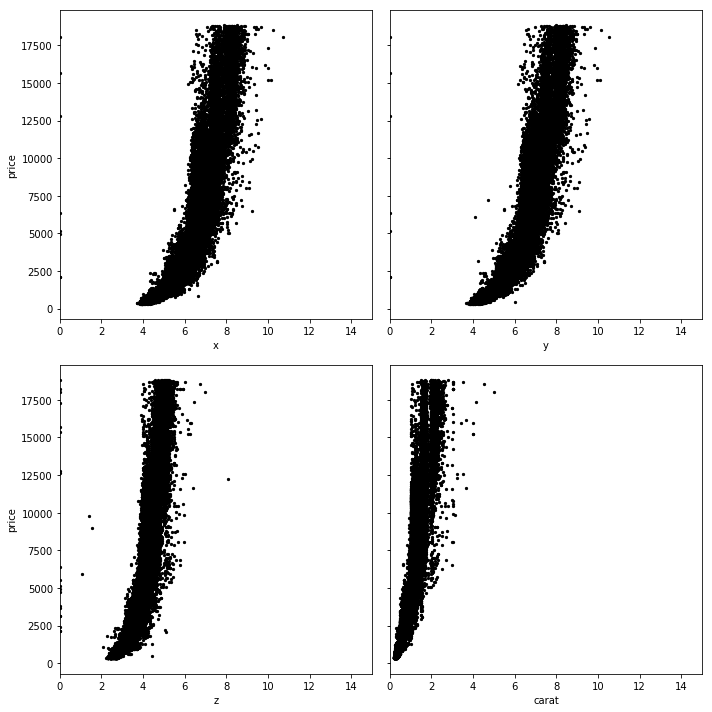

In [3]:
f,axs = plt.subplots(2,2,figsize=(10,10),sharey=True)

_vars = ['x','y','z','carat']

for i,_ax in enumerate(axs.flatten()):
    diamonds_df.plot.scatter(x=_vars[i],y='price',ax=_ax,s=5,c='k')
    _ax.set_xlim((0,15))
    
f.tight_layout()

These look quadratic, rather than linear (more on that below), but let's go ahead with a linear model. 

$$price = \beta_0 + \beta_1x + \beta_2y + \beta_3z + \beta_4carat$$

Every additional carat increases the price of the diamond by about 10k, every additional millimeter of "x" reduces the price by 884, every additional millimeter of "y" increases the price by 166, and every additional millimeter of "z" reduces the price by 576. All of these effects were statistically significant at the $p<0.05$ level.

Even though our simple EDA of price and dimensions suggested the relationship is non-linear, our linear model still has an $R^2$ of 0.854, an outstanding fit.

In [4]:
m0 = smf.ols(formula = 'price ~ x + y + z + carat',data=diamonds_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 7.892e+04
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:07:09   Log-Likelihood:            -4.7187e+05
No. Observations:               53940   AIC:                         9.437e+05
Df Residuals:                   53935   BIC:                         9.438e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1921.1740    104.373     18.407      0.000    1716.601    2125.747
x           -884.2091     40.470    -21.848      0.000    -963.532    -804.887
y            166.0384     25.858      6.421      0.000     115.356     216.721
z           -576.2035     39.282    -14.668      0.000    -653.197    -499.210
carat       1.023e+04     62.937    162.607      0.000    1.01e+04    1.04e+04
==============================================================================
Omnibus:                    14400.324   Durbin-Watson:                   1.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           336485.128
Skew:                           0.743   Prob(JB):                         0.00
Kurtosis:                      15.145   Cond. No.                         171.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
m0.predict({'x':40,'y':20,'z':40,'carat':1})

0   -42940.647634
dtype: float64

## Assumption 1: Linear relationship

Our EDA above suggested the relationship between these variables was potentially quadratic rather than linear. Let's take carat against price for example.

(0, 20000)

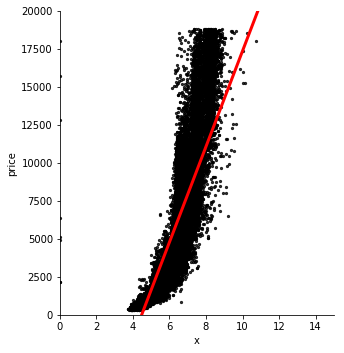

In [11]:
g = sb.lmplot(x='x',y='price',data=diamonds_df,
          ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})

ax = g.axes[0,0]
ax.set_xlim((0,15))
ax.set_ylim((0,20000))

We can use `lmplot`'s "order" parameter to specify a higher-order polynomial for this data. This is already a better fit for the data, but makes unreasonable predictions for low values of "x".

(0, 20000)

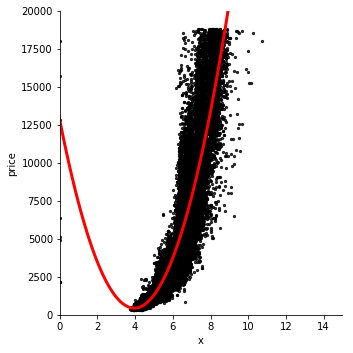

In [12]:
g = sb.lmplot(x='x',y='price',data=diamonds_df,order=2,
          ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})

ax = g.axes[0,0]
ax.set_xlim((0,15))
ax.set_ylim((0,20000))

We can specify higher-order relationships if the data is non-linear in statsmodels. Here let's add polynomial terms for all the x, y, z, and carat variables.

$$price = \beta_0 + \beta_1x + \beta_2x^2 + \beta_3y + \beta_4y^2 + \beta_5z + \beta_6z^2 + \beta_7carat + \beta_8carat^2$$

In [13]:
m1 = smf.ols(formula = 'price ~ x + np.power(x,2) + y + np.power(y,2) + z + np.power(z,2) + carat + np.power(carat,2)',data=diamonds_df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 4.294e+04
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:11:50   Log-Likelihood:            -4.6991e+05
No. Observations:               53940   AIC:                         9.398e+05
Df Residuals:                   53931   BIC:                         9.399e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.846e+04    296.186     62.319      0.000    1.79e+04     1.9e+04
x                  -1.013e+04    171.056    -59.206      0.000   -1.05e+04   -9792.204
np.power(x, 2)       881.9349     15.703     56.162      0.000     851.156     912.714
y                   1611.1453     88.673     18.170      0.000    1437.346    1784.945
np.power(y, 2)       -25.8286      1.480    -17.453      0.000     -28.729     -22.928
z                    533.3066     85.284      6.253      0.000     366.149     700.464
np.power(z, 2)       -14.1386      2.982     -4.741      0.000     -19.984      -8.293
carat               5692.1493    239.288     23.788      0.000    5223.143    6161.155
np.power(carat, 2) -1349.1314     39.579    -34.087      0.000   -1426.707   -1271.556
==============================================================================
Omnibus:                    14279.416   Durbin-Watson:                   1.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           360211.832
Skew:                           0.708   Prob(JB):                         0.00
Kurtosis:                      15.580   Cond. No.                     2.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumption 2: Variables are normally distributed

The second assumption that linear regression makes is that the variables are normally distributed. 

This is what a normal distribution looks like:

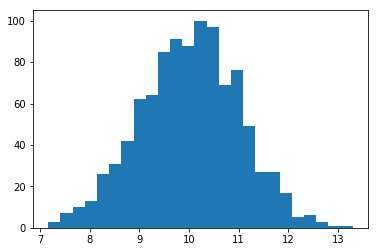

In [14]:
plt.hist(np.random.normal(loc=10,size=1000),bins=25);

Many kinds of data do not follow a normal distribution and are "right" [skewed](https://en.wikipedia.org/wiki/Skewness) with most observations being low counts but a few observations being high counts.

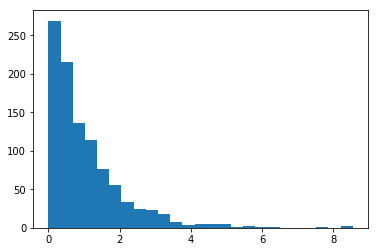

In [15]:
plt.hist(np.random.exponential(scale=1,size=1000),bins=25);

Some of the variables in the `diamonds_df` follow a similar right skewed pattern.

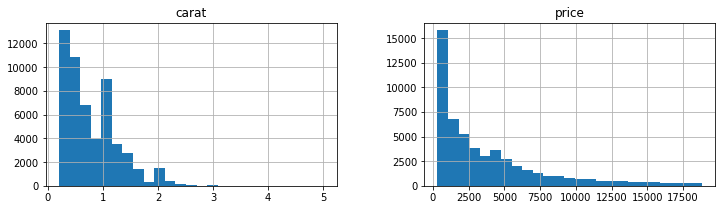

In [16]:
diamonds_df[['price','carat']].hist(bins=25,layout=(1,2),figsize=(12,3));

Others, like the dimensions, show a more normal distribution.

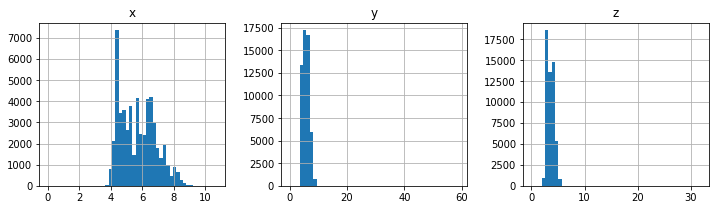

In [17]:
diamonds_df[['x','y','z']].hist(bins=50,layout=(1,3),figsize=(12,3));

We can transform right-skewed data using a logarithm. These aren't perfect normal distributions, but they are much closer than they were before.

In [18]:
diamonds_df[['log_price','log_carat']] = diamonds_df[['price','carat']].apply(np.log)
diamonds_df[['price','log_price','carat','log_carat']].head()

,price,log_price,carat,log_carat
1,326,5.786897,0.23,-1.469676
2,326,5.786897,0.21,-1.560648
3,327,5.789960,0.23,-1.469676
4,334,5.811141,0.29,-1.237874
5,335,5.814131,0.31,-1.171183


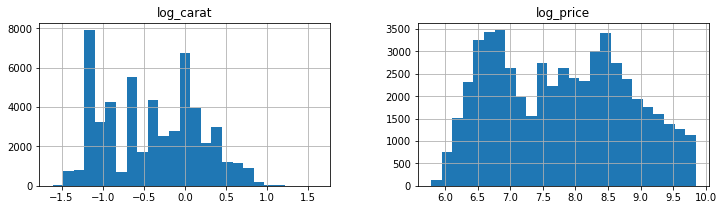

In [19]:
diamonds_df[['log_price','log_carat']].hist(bins=25,layout=(1,2),figsize=(12,3));

If use log-transformed values for price and carat, the linear model we're estimating becomes:

$$log(price) = \beta_0 + \beta_1x + \beta_2y + \beta_3z + \beta_4log(carat)$$

The $R^2$ value increased substantiall compared to Model 0, from 0.854 to 0.933! The AIC and BIC both decreased substanially, more evidence that Model 2 is better than Model 0!

In [21]:
m2 = smf.ols(formula = 'log_price ~ x + y + z + log_carat',data=diamonds_df).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.884e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:15:16   Log-Likelihood:                -4335.0
No. Observations:               53940   AIC:                             8680.
Df Residuals:                   53935   BIC:                             8724.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0404      0.048    167.403      0.000       7.946       8.134
x              0.0693      0.009      8.121      0.000       0.053       0.086
y              0.0242      0.004      5.440      0.000       0.015       0.033
z             -0.0493      0.007     -7.161      0.000      -0.063      -0.036
log_carat      1.5563      0.014    109.638      0.000       1.528       1.584
==============================================================================
Omnibus:                      969.809   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1924.455
Skew:                           0.077   Prob(JB):                         0.00
Kurtosis:                       3.912   Cond. No.                         406.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
m2 = smf.ols(formula = 'np.log(price) ~ x + y + z + np.log(carat)',data=diamonds_df).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.884e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:15:03   Log-Likelihood:                -4335.0
No. Observations:               53940   AIC:                             8680.
Df Residuals:                   53935   BIC:                             8724.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.0404      0.048    167.403      0.000       7.946       8.134
x                 0.0693      0.009      8.121      0.000       0.053       0.086
y                 0.0242      0.004      5.440      0.000       0.015       0.033
z                -0.0493      0.007     -7.161      0.000      -0.063      -0.036
np.log(carat)     1.5563      0.014    109.638      0.000       1.528       1.584
==============================================================================
Omnibus:                      969.809   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1924.455
Skew:                           0.077   Prob(JB):                         0.00
Kurtosis:                       3.912   Cond. No.                         406.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However, the interpretation of the co-efficients is now in log-dollars, rather than dollars. You can always exponentiate the coefficients to recover their non-log dollar value. Log-carats would need to be exponentiated again.

In [22]:
m2.params.apply(np.exp)

Intercept    3103.717066
x               1.071707
y               1.024502
z               0.951855
log_carat       4.741237
dtype: float64

In [23]:
np.exp(4.741237)

114.5758443755827

In [27]:
np.log(1)

0.0

In [29]:
np.exp(m2.predict({'x':40,'y':20,'z':40,'log_carat':0}))

0    11168.712741
dtype: float64

## Assumption 3: No multicollinearity

The third assumption that linear regression makes is that the features (independent variables, Xs, *etc*.) are not correlated with each other.

In class 33, we saw that many of the variables in the World Happiness Index were strongly correlated with each other by using a correlation heatmap. Doing the same for `diamonds_df`, we seee the variables have extremely high levels of correlation with each other. 

This is not a *fatal* flaw for a regression, but it typically means the estimated standard errors on the coefficients are larger than they otherwise would be. In other words, multicollinear variables in a regression may not light up statistically significant, even when they are because of these over-dispersed errors.

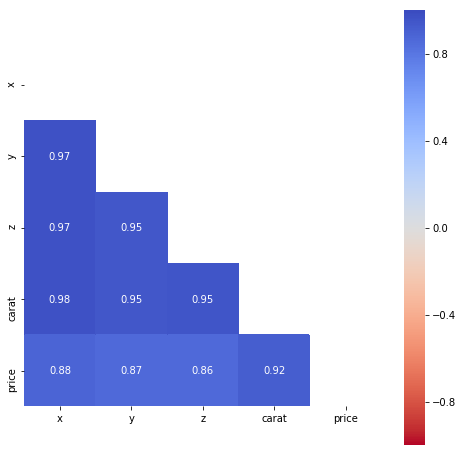

In [30]:
diamonds_corr =  diamonds_df[['x','y','z','carat','price']].corr()

# Using masking code from: https://seaborn.pydata.org/generated/seaborn.heatmap.html
diamonds_mask = np.zeros_like(diamonds_corr)
diamonds_mask[np.triu_indices_from(diamonds_mask)] = True

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(8,8))

# Make a heatmap
sb.heatmap(diamonds_corr,vmin=-1,vmax=1,mask=diamonds_mask,annot=True,square=True,ax=ax,cmap='coolwarm_r')

Some solutions for addressing multicollinearity include:
1. Remove the correlated variables from the model. In practice, this is hard to do since you have have justified theoretical or explanatory needs for getting estimates and significance tests for each of the variables.
2. Reduce the correlated variables using dimensionality reduction techniques like principal component analysis (PCA). This is an advanced technique outside the scope of this class, but should produce fewer variables that are less correlated with each other.
3. Increase the power of the analysis, *A.K.A* get more data. Because multicollinearity inflates the standard errors making significant variables non-significant, getting more data will counter-act this by allowing more precise estimates of error terms. This is probably the most general advice: you don't need to worry about multicollinearity if you have lots of data.

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(diamonds_df[['x','y','z','carat']])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

We asked for two dimensions, how much of the variance do each of these dimensions explain in the input features (x, y, z, carat)? The first dimension explains 97.8% of the variance and the second explains 1.3% of the variance. Basically, we can just use this first dimension of the PCA as an input variable rather than the 4 original input variables and get 97.8% of the way there.

In [32]:
pca.explained_variance_ratio_

array([0.97829108, 0.01269288])

`.transform()` the input variables using the PCA model and estimate a model using only the PCA dimensions.

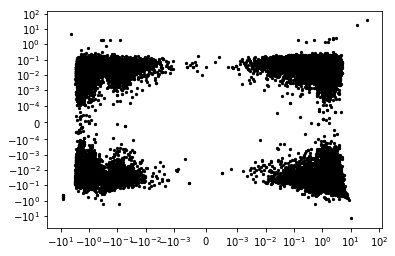

In [33]:
# Transform the variables into PCA values using the PCA model
X_pca = pca.transform(diamonds_df[['x','y','z','carat']])

# Visualize the two dimensions of PCA variables
plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c='k')
plt.xscale('symlog',linthreshx=1e-3)
plt.yscale('symlog',linthreshy=1e-4)

This reduced dimensionality model does an *outstanding* job predicting price ($R^2=0.913$) but at the cost of interpretability since we no longer have meaningful units to say what a one unit increase in X_pca_0 has on (log) price.

In general, multicollinearity is a nuisance rather than a fatal problem and can typically be addressed by having a large sample to analyze.

In [34]:
# Put the first dimension into the DataFrame
diamonds_df['X_pca_0'] = X_pca[:,0]
# Put the second dimension into the DataFrame
diamonds_df['X_pca_1'] = X_pca[:,1]

# Estimate a model using only X_pca
m3 = smf.ols(formula = 'np.log(price) ~ X_pca_0 + X_pca_1',data=diamonds_df).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 2.821e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:24:52   Log-Likelihood:                -11541.
No. Observations:               53940   AIC:                         2.309e+04
Df Residuals:                   53937   BIC:                         2.312e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7868      0.001   6034.123      0.000       7.784       7.789
X_pca_0        0.5398      0.001    749.901      0.000       0.538       0.541
X_pca_1       -0.2772      0.006    -43.865      0.000      -0.290      -0.265
==============================================================================
Omnibus:                    18228.480   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4905550.636
Skew:                          -0.289   Prob(JB):                         0.00
Kurtosis:                      49.715   Cond. No.                         8.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Assumption 4: No auto-correlation

The fourth assumption of linear regression is that observations are independent from one another. In the case of our diamonds data, the size, quality, and price of one diamond should not influence the size, quality, and price of other diamonds. This is a reasonable assumption in this context, but becomes less reasonable in many social contexts where behaviors can be influence or tend to cluster. 

For example, the distribution of weight in a population (particularly a social network) is [not random or independent](https://www.nejm.org/doi/full/10.1056/NEJMsa066082): overweight people tend to be friends with other overweight people, whether that's because they preferentially seek out friendships with others having similar behaviors (homophily) or because they persuade their friends to adopt their own behaviors (influence).

Auto-correlation is easiest to understand in the context of time series: the weather today tends to be related to both the weather yesterday and the weather tomorrow. We'll return to the idea of auto-correlation in the next module about forecasting.

## Assumption 5: No heteroskedasticity

The fourth assumption of linear regression is homoskedasticity, or identically distributed. The opposite of homoskedasticity is heteroskedasticity where the distribution of data changes over the range of values.

We can see an example of heteroskedasticity most clearly in the relationship between carat and price. The variance in prices for smaller carats is much lower than the variance in prices for larger carats.

(0, 20000)

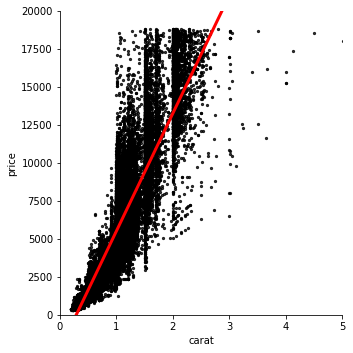

In [35]:
g = sb.lmplot(x='carat',y='price',data=diamonds_df,
          ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})

ax = g.axes[0,0]
ax.set_xlim((0,5))
ax.set_ylim((0,20000))

For example, the standard deviation in prices for 1 carat diamonds is 1603, 2998 for 2 carats, and 3881 for 3 carats. Because the variance (standard deviations) increases over this range of carats—rather than staying constant—this is an example of heteroskedasticity. 

In [36]:
diamonds_df.loc[diamonds_df['carat'] == 1,'price'].std()

1603.9390491208362

In [37]:
diamonds_df.loc[diamonds_df['carat'] == 2,'price'].std()

2998.2295483048297

In [38]:
diamonds_df.loc[diamonds_df['carat'] == 3,'price'].std()

3881.8770864474463

We can also diagnose heteroskedasticity by inspecting the residual plots. The top two plots are the most helpful for our purposes. You can read more about how to interpret these plots here: https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html

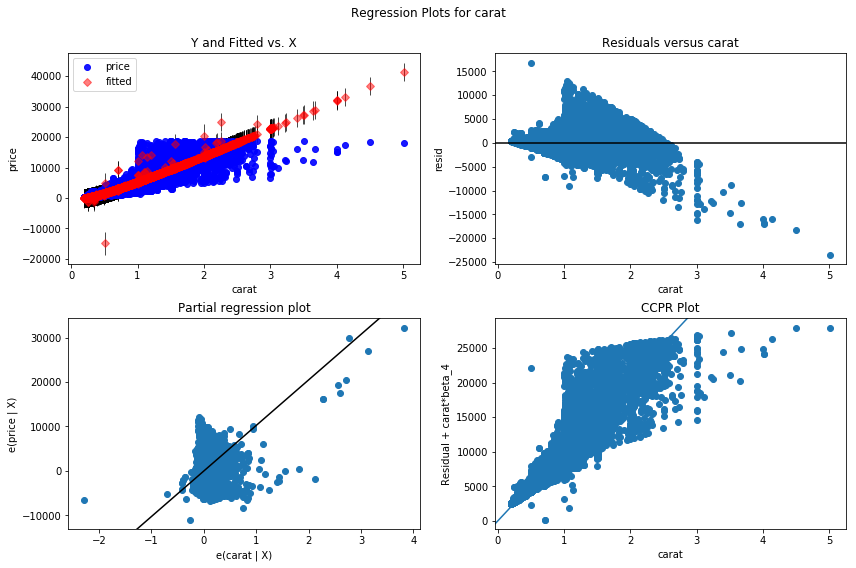

In [39]:
f = plt.figure(figsize=(12,8))
f = sm.graphics.plot_regress_exog(m0,"carat",fig=f)

Like multicollinearily, heteroskedasticity can inflate/deflate the estimated coefficients and standard errors potentially resulting in non-significant findings becoming significant or significant findings becoming non-significant.

The most common way to handle heteroskedastic data is to apply a transformation like the [Box-Cox](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation) on the dependent variable.

In [40]:
from scipy.stats import boxcox
diamonds_df['price_boxcox'] = boxcox(diamonds_df['price'])[0]

Inspect the relationship.

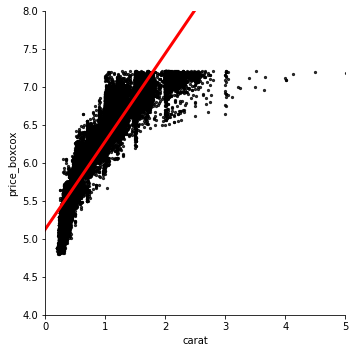

In [41]:
g = sb.lmplot(x='carat',y='price_boxcox',data=diamonds_df,
          ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})

ax = g.axes[0,0]
ax.set_xlim((0,5))
ax.set_ylim((4,8));

How does the variance for different carats change now? This is much more consistent than before in terms of absolute variance.

In [42]:
diamonds_df.loc[diamonds_df['carat'] == 1,'price_boxcox'].std()

0.16285530302802867

In [43]:
diamonds_df.loc[diamonds_df['carat'] == 2,'price_boxcox'].std()

0.12940230309729564

In [44]:
diamonds_df.loc[diamonds_df['carat'] == 3,'price_boxcox'].std()

0.18594052870413622

Estimate a regression model using the Box-Cox transformed dependent variable. The performance of this model is substantially better ($R^2=0.921$) than Model 0 ($R^2=0.854$) and the AIC and BIC scores also reflect this. The trade-off is the interpretability of the model has decreased: it's not obvious how to interpret a one-unit change in x or carat on Box-Cox transformed price. Like multicollinearity, heteroskedasticity is mostly a nuisance but not necessarily fatal to your analysis.

In [46]:
m5 = smf.ols(formula = 'price_boxcox ~ x + y + z + np.log(carat)',data=diamonds_df).fit()
m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_boxcox   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.878e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:32:04   Log-Likelihood:                 23827.
No. Observations:               53940   AIC:                        -4.764e+04
Df Residuals:                   53935   BIC:                        -4.760e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.6749      0.028    234.247      0.000       6.619       6.731
x                -0.0217      0.005     -4.291      0.000      -0.032      -0.012
y                 0.0122      0.003      4.620      0.000       0.007       0.017
z                -0.0436      0.004    -10.656      0.000      -0.052      -0.036
np.log(carat)     1.0618      0.008    126.081      0.000       1.045       1.078
==============================================================================
Omnibus:                      762.027   Durbin-Watson:                   1.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1448.922
Skew:                          -0.009   Prob(JB):                         0.00
Kurtosis:                       3.803   Cond. No.                         406.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Working with categorical or binary data

The `diamonds_df` data also includes a number of categorical variables like cut, color, and clarity. For two diamonds of identical size and weight, these variables exert a very strong influence on price.

In [47]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,log_price,log_carat,X_pca_0,X_pca_1,price_boxcox
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,5.786897,-1.469676,-2.788651,0.004464,4.797128
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,5.786897,-1.560648,-2.965656,-0.015756,4.797128
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,5.789960,-1.469676,-2.715772,0.094481,4.799206
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,5.811141,-1.237874,-2.382894,-0.010669,4.813567
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,5.814131,-1.171183,-2.168719,-0.035114,4.815592


Make some exploratory category plots of how these categorical variables vary with price. Interestingly, the "best" categories have the lowest average prices. This is misleading because of how the data was censored (no diamonds above $20k).

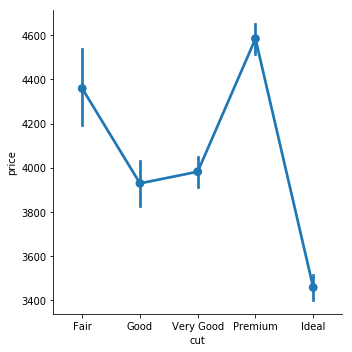

In [48]:
sb.catplot(x='cut',y='price',data=diamonds_df,kind='point',order=['Fair','Good','Very Good','Premium','Ideal'])

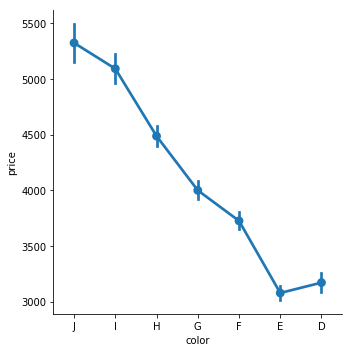

In [49]:
sb.catplot(x='color',y='price',data=diamonds_df,kind='point',order=['D','E','F','G','H','I','J'][::-1])

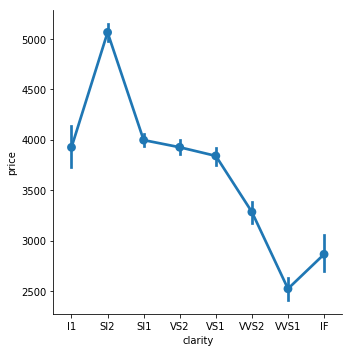

In [50]:
sb.catplot(x='clarity',y='price',data=diamonds_df,kind='point',order=['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF'])

Try another visualization approach combining some of these categorical variables.

In [ ]:
g = sb.catplot(x='carat',y='price',col='cut',hue='clarity',data=diamonds_df,
               col_order=['Fair','Good','Very Good','Premium','Ideal'],
               hue_order=['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF'])

We can represent these categorical variables in a regression as well. There are now many more parameters in the model, each of these additional parameters corresponds to the category levels. This is the best performing model to date ($R^2=0.967$). All of these coefficients are statistically significant.

Note that for the categorical variables, a single variable is missing: this is the base case that we interpret the results against.

* **cut**: The "Fair" cut is missing so we interpret the results of these coefficients conditional on the Fair cut: "all else being equal, an ideal cut is worth 0.0378 log-dollars more than a fair cut". 
* **clarity**: The "I1" category is missing a coefficient, so we can interpret the coefficient for IF as: "all else being equal, an IF clarity diamond is worth 1.06 log-dollars more than a I1 clarity diamond." 
* **color**: The "D" category is missing from the "color" variable so we can interpret the coefficient for "J" as: "all else being equal, a J color diamond is worth 0.5199 log-dollars less than a D color diamond."

However, some of these coefficients are still somewhat nonsensical on the surface: the estimated coefficient for carat is negative, implying that all other things being equal, heavier diamonds are worth less than lighter diamonds.

In [52]:
m6 = smf.ols(formula = 'np.log(price) ~ x + y + z + np.log(carat) + C(cut) + C(clarity) + C(color)',data=diamonds_df).fit()
m6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.457e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:35:38   Log-Likelihood:                 32072.
No. Observations:               53940   AIC:                        -6.410e+04
Df Residuals:                   53918   BIC:                        -6.390e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.4967      0.026    293.146      0.000       7.447       7.547
C(cut)[T.Good]          0.0778      0.004     19.915      0.000       0.070       0.085
C(cut)[T.Ideal]         0.1556      0.004     43.275      0.000       0.149       0.163
C(cut)[T.Premium]       0.1324      0.004     36.221      0.000       0.125       0.140
C(cut)[T.Very Good]     0.1131      0.004     30.967      0.000       0.106       0.120
C(clarity)[T.IF]        1.1138      0.006    185.024      0.000       1.102       1.126
C(clarity)[T.SI1]       0.5961      0.005    115.885      0.000       0.586       0.606
C(clarity)[T.SI2]       0.4296      0.005     83.094      0.000       0.419       0.440
C(clarity)[T.VS1]       0.8146      0.005    155.172      0.000       0.804       0.825
C(clarity)[T.VS2]       0.7446      0.005    143.998      0.000       0.734       0.755
C(clarity)[T.VVS1]      1.0194      0.006    183.166      0.000       1.008       1.030
C(clarity)[T.VVS2]      0.9484      0.005    175.327      0.000       0.938       0.959
C(color)[T.E]          -0.0546      0.002    -25.826      0.000      -0.059      -0.050
C(color)[T.F]          -0.0944      0.002    -44.159      0.000      -0.099      -0.090
C(color)[T.G]          -0.1605      0.002    -76.701      0.000      -0.165      -0.156
C(color)[T.H]          -0.2524      0.002   -113.567      0.000      -0.257      -0.248
C(color)[T.I]          -0.3751      0.002   -150.423      0.000      -0.380      -0.370
C(color)[T.J]          -0.5143      0.003   -167.152      0.000      -0.520      -0.508
x                       0.0513      0.004     11.419      0.000       0.043       0.060
y                      -0.0020      0.002     -0.897      0.370      -0.007       0.002
z                       0.0111      0.004      3.124      0.002       0.004       0.018
np.log(carat)           1.7771      0.007    238.107      0.000       1.763       1.792
==============================================================================
Omnibus:                     3555.889   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15399.059
Skew:                           0.172   Prob(JB):                         0.00
Kurtosis:                       5.595   Cond. No.                         426.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
np.exp(m6.predict({'x':40,'y':20,'z':40,'carat':.5,'cut':'Premium','color':'J','clarity':'VVS1'}))

0    11604.985325
dtype: float64

## Exercise
Let's use the World Bank's [World Development Indicators](https://datacatalog.worldbank.org/dataset/world-development-indicators) as an example of a dataset that requires a bit more exploration and pre-processing in order to satisfy assumptions about regression.

In [60]:
wdi_df = pd.read_csv('world_development_indicators_2016.csv')
wdi_df.head()

,Country Name,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: mineral depletion (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)","Agriculture, forestry, and fishing, value added (annual % growth)","Agriculture, forestry, and fishing, value added (constant 2010 US$)","Agriculture, forestry, and fishing, value added (current US$)",Aquaculture production (metric tons),Arable land (% of land area),Arable land (hectares per person),"Armed forces personnel, total","Birth rate, crude (per 1,000 people)",Business extent of disclosure index (0=less disclosure to 10=more disclosure),Capture fisheries production (metric tons),"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)","Cause of death, by injury (% of total)","Cause of death, by non-communicable diseases (% of total)",Cereal production (metric tons),Cereal yield (kg per hectare),"Claims on central government, etc. (% GDP)",Coal rents (% of GDP),Commercial service exports (current US$),Commercial service imports (current US$),"Communications, computer, etc. (% of service exports, BoP)","Communications, computer, etc. (% of service imports, BoP)","Compulsory education, duration (years)","Computer, communications and other services (% of commercial service exports)","Computer, communications and other services (% of commercial service imports)","Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)","Contributing family workers, total (% of total employment) (modeled ILO estimate)",Cost of business start-up procedures (% of GNI per capita),"Cost of business start-up procedures, female (% of GNI per capita)","Cost of business start-up procedures, male (% of GNI per capita)","Cost to export, border compliance (US$)","Cost to export, documentary compliance (US$)","Cost to import, border compliance (US$)","Cost to import, documentary compliance (US$)","Death rate, crude (per 1,000 people)",Depth of credit information index (0=low to 8=high),Distance to frontier score (0=lowest performance to 100=frontier),Domestic credit provided by financial sector (% of GDP),Domestic credit to private sector (% of GDP),Domestic credit to private sector by banks (% of GDP),"Employers, female (% of female employment) (modeled ILO estimate)","Employers, male (% of male employment) (modeled ILO estimate)","Employers, total (% of total employment) (modeled ILO estimate)",Employment in agriculture (% of total employment) (modeled ILO estimate),"Employment in agriculture, female (% of female employment) (modeled ILO estimate)","Employment in agriculture, male (% of male employment) (modeled ILO estimate)",Employment in industry (% of total employment) (modeled ILO estimate),"Employment in industry, female (% of female employment) (modeled ILO estimate)","Employment in industry, male (% of male employment) (modeled ILO estimate)",Employment in services (% of total employment) (modeled ILO estimate),"Employment in services, female (% of female employment) (modeled ILO estimate)","Employment in services, male (% of male employment) (modeled ILO estimate)","Employment to population ratio, 15+, female (%) (modeled ILO estimate)","Employment to population ratio, 15+, male (%) (modeled ILO estimate)","Employment to population ratio, 15+, total (%) (modeled ILO estimate)","Employment to population ratio, ages 15-24, female (%) (modeled ILO estimate)","Emp

In [62]:
list(wdi_df.columns)

['Country Name',
 'Access to clean fuels and technologies for cooking (% of population)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Adjusted savings: mineral depletion (current US$)',
 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Age dependency ratio (% of working-age population)',
 'Age dependency ratio, old (% of working-age population)',
 'Age dependency ratio, young (% of working-age population)',
 'Agricultural land (% of land area)',
 'Agricultural land (sq. km)',
 'Agriculture, forestry, and fishing, value added (% of GDP)',
 'Agriculture, forestry, and fishing, value added (annual % growth)',
 'Agriculture, forestry, and fishing, value added (constant 2010 US$)',
 'Agriculture, forestry, and fishing, value added (current US$)',
 'Aquaculture production (metric tons)',
 'Arable land (% of land area)',
 'Arable land (hectares per person)',
 '

Create a sub-DataFrame with only the relevant columns you want to use in your analysis.

In [63]:
wdi_subdf = wdi_df[['Mortality rate attributed to household and ambient air pollution, age-standardized (per 100,000 population)',
        'Mobile cellular subscriptions (per 100 people)',
        'Forest area (% of land area)']]

Rename the columns so they do not have spaces in them.

In [64]:
wdi_subdf.columns = ['pollution','cellular','forest']

Create some exploratory plots for the relationships between these variables. Are these linear relationships?

Make a correlation heatmap to diagnose potential sources of multicollinearity.

In [65]:
wdi_subdf.corr()

,pollution,cellular,forest
pollution,1.000000,-0.590434,-0.114971
cellular,-0.590434,1.000000,0.011291
forest,-0.114971,0.011291,1.000000


Make some histograms of the distributions of these variables. Are they normally-distributed or right skewed?

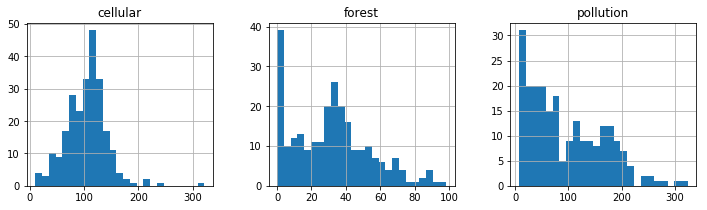

In [70]:
wdi_subdf.hist(layout=(1,3),figsize=(12,3),bins=25);

Specify the simplest possible linear regression model. Interpret the results.

In [72]:
wdi_m0 = smf.ols(formula = 'pollution ~ cellular + forest',data=wdi_subdf).fit()
wdi_m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pollution   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     61.84
Date:                Wed, 10 Apr 2019   Prob (F-statistic):           4.30e-22
Time:                        11:49:08   Log-Likelihood:                -1230.0
No. Observations:                 226   AIC:                             2466.
Df Residuals:                     223   BIC:                             2476.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    229.7090     13.106     17.528      0.000     203.882     255.536
cellular      -1.1868      0.109    -10.913      0.000      -1.401      -0.973
forest        -0.3630      0.171     -2.122      0.035      -0.700      -0.026
==============================================================================
Omnibus:                       27.918   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.860
Skew:                           0.806   Prob(JB):                     9.91e-09
Kurtosis:                       4.146   Cond. No.                         400.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Specify alternative regression models including transformations, polynomial features, (not present in this data) or categorical features.

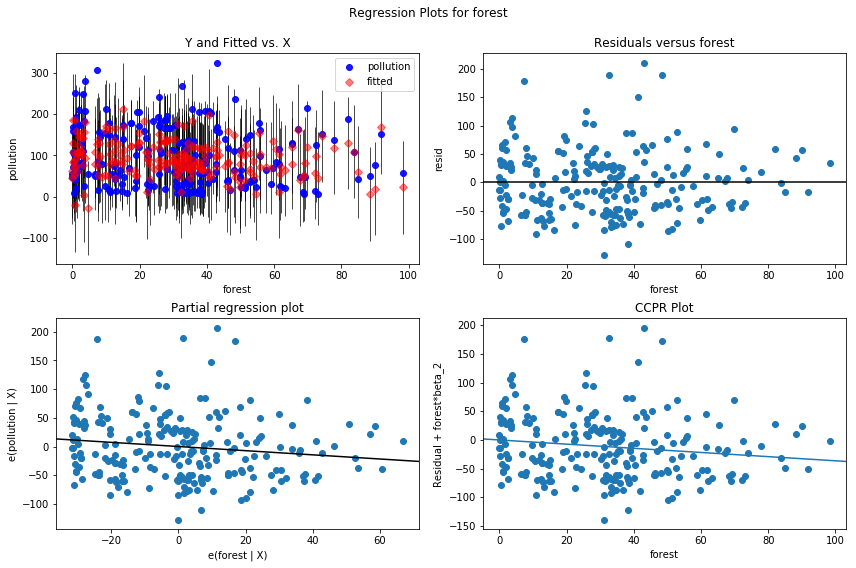

In [73]:
f = plt.figure(figsize=(12,8))
f = sm.graphics.plot_regress_exog(wdi_m0,"forest",fig=f)